Epoch 1/10, Loss: 0.3610
Epoch 2/10, Loss: 0.3154
Epoch 3/10, Loss: 0.3105
Epoch 4/10, Loss: 0.3085
Epoch 5/10, Loss: 0.3063
Epoch 6/10, Loss: 0.3044
Epoch 7/10, Loss: 0.3021
Epoch 8/10, Loss: 0.3012
Epoch 9/10, Loss: 0.2999
Epoch 10/10, Loss: 0.2968


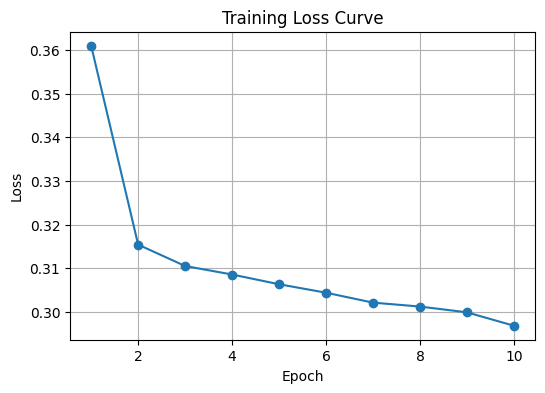

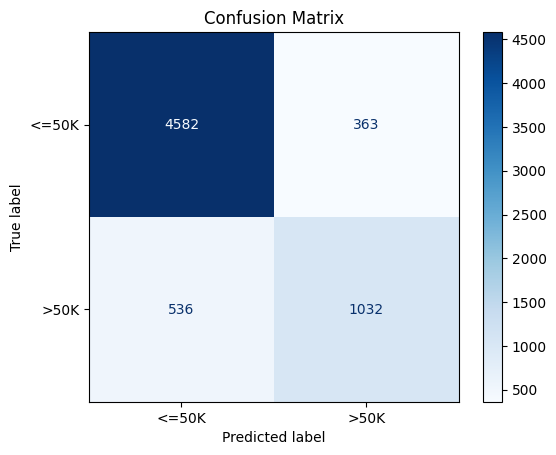

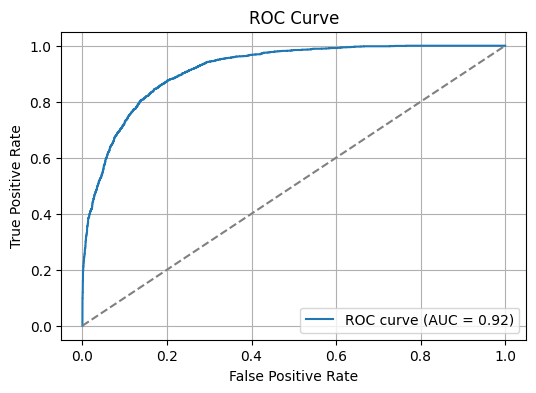

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# 1. 加载数据
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
col_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
df = pd.read_csv(url, header=None, names=col_names, na_values=" ?", skipinitialspace=True)

# 2. 标签处理
y = df["income"].apply(lambda v: 1 if v.strip() == ">50K" else 0).values
X = df.drop("income", axis=1)

# 3. 特征工程
numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])
X_processed = preprocessor.fit_transform(X)
X_processed = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

# 4. 划分训练/测试
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 5. 定义神经网络
class IncomeNet(nn.Module):
    def __init__(self, input_dim):
        super(IncomeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = IncomeNet(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. 训练 & 记录 loss
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# 7. 可视化 Loss 曲线
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 8. 模型评估
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy().flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50, Loss: 0.3441
Epoch 2/50, Loss: 0.3129
Epoch 3/50, Loss: 0.3093
Epoch 4/50, Loss: 0.3071
Epoch 5/50, Loss: 0.3047
Epoch 6/50, Loss: 0.3045
Epoch 7/50, Loss: 0.3001
Epoch 8/50, Loss: 0.2977
Epoch 9/50, Loss: 0.2990
Epoch 10/50, Loss: 0.2965
Epoch 11/50, Loss: 0.2935
Epoch 12/50, Loss: 0.2916
Epoch 13/50, Loss: 0.2965
Epoch 14/50, Loss: 0.2950
Epoch 15/50, Loss: 0.2863
Epoch 16/50, Loss: 0.2851
Epoch 17/50, Loss: 0.2837
Epoch 18/50, Loss: 0.2852
Epoch 19/50, Loss: 0.2809
Epoch 20/50, Loss: 0.2852
Epoch 21/50, Loss: 0.2808
Epoch 22/50, Loss: 0.2784
Epoch 23/50, Loss: 0.2773
Epoch 24/50, Loss: 0.2765
Epoch 25/50, Loss: 0.2752
Epoch 26/50, Loss: 0.2799
Epoch 27/50, Loss: 0.2766
Epoch 28/50, Loss: 0.2791
Epoch 29/50, Loss: 0.2787
Epoch 30/50, Loss: 0.2696
Epoch 31/50, Loss: 0.2747
Epoch 32/50, Loss: 0.2710
Epoch 33/50, Loss: 0.2690
Epoch 34/50, Loss: 0.2763
Epoch 35/50, Loss: 0.2713
Epoch 36/50, Loss: 0.2647
Epoch 37/50, Loss: 0.2646
Epoch 38/50, Loss: 0.2653
Epoch 39/50, Loss: 0.

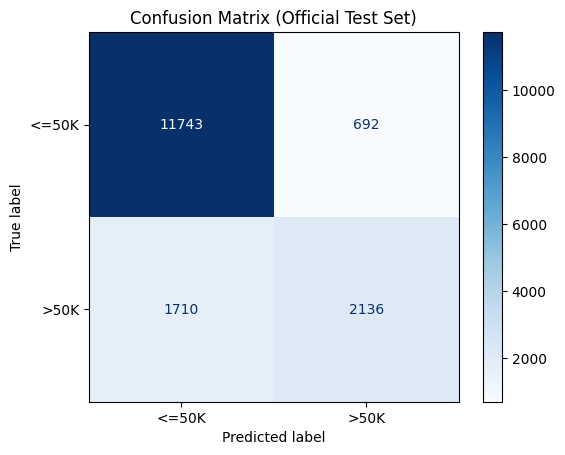

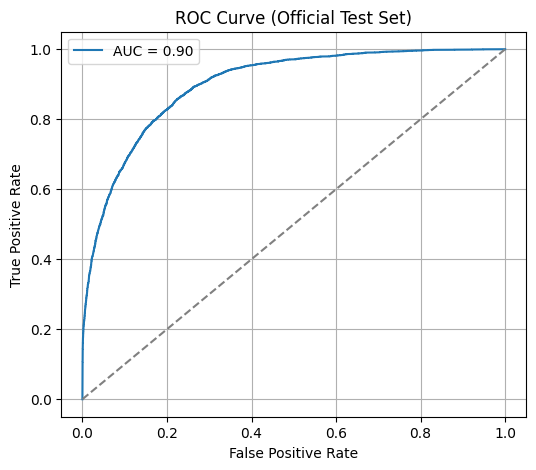


=== Classification Report ===
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.91     12435
        >50K       0.76      0.56      0.64      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.75      0.77     16281
weighted avg       0.85      0.85      0.84     16281

Overall Accuracy: 0.8525

=== Example Predictions ===
Sample  8050 | True: <=50K | Pred: <=50K | Prob: 0.398
Sample  5181 | True:  >50K | Pred: <=50K | Prob: 0.448
Sample  2658 | True: <=50K | Pred: <=50K | Prob: 0.006
Sample  6888 | True: <=50K | Pred: <=50K | Prob: 0.090
Sample  9948 | True:  >50K | Pred:  >50K | Prob: 0.989
Sample 12971 | True: <=50K | Pred: <=50K | Prob: 0.481
Sample 10150 | True: <=50K | Pred: <=50K | Prob: 0.000
Sample  4581 | True: <=50K | Pred: <=50K | Prob: 0.000
Sample  5961 | True: <=50K | Pred:  >50K | Prob: 0.661
Sample  1999 | True: <=50K | Pred: <=50K | Prob: 0.009


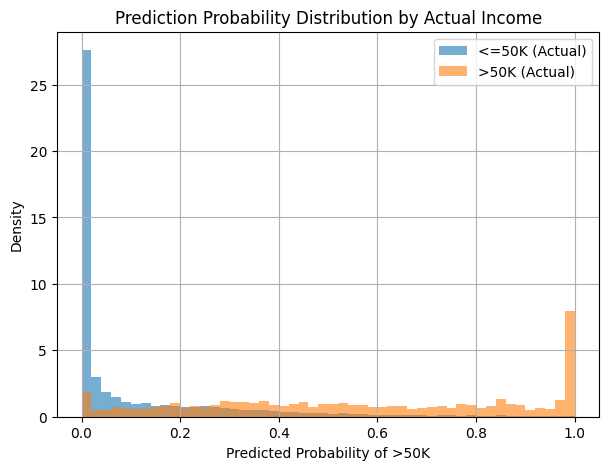

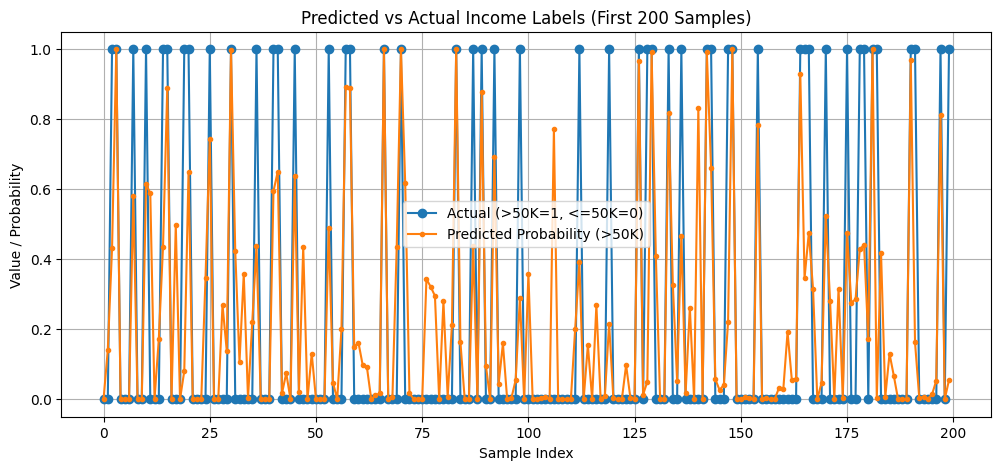

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

def load_adult_data():
    # 列名
    col_names = [
        "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
        "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
        "hours-per-week", "native-country", "income"
    ]

    # 训练集
    train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    df_train = pd.read_csv(train_url, header=None, names=col_names, na_values=" ?", skipinitialspace=True)

    # 测试集
    test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
    df_test = pd.read_csv(test_url, header=0, names=col_names, na_values=" ?", skipinitialspace=True)

    # 去掉标签里的 "." 符号
    df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

    return df_train, df_test

def preprocess_data(df_train, df_test):
    # 分离特征与标签
    X_train, y_train = df_train.drop("income", axis=1), df_train["income"]
    X_test, y_test = df_test.drop("income", axis=1), df_test["income"]

    # 转换标签为 0/1
    y_train = y_train.apply(lambda v: 1 if v.strip() == ">50K" else 0).values
    y_test = y_test.apply(lambda v: 1 if v.strip() == ">50K" else 0).values

    # 数值/类别特征
    numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
    categorical_features = ["workclass", "education", "marital-status", "occupation",
                            "relationship", "race", "sex", "native-country"]

    # 预处理管道
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # 拟合 & 转换
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, y_train, X_test_processed, y_test

class IncomeNet(nn.Module):
    def __init__(self, input_dim):
        super(IncomeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

def main():
    # 1. 加载官方 train/test
    df_train, df_test = load_adult_data()

    # 2. 预处理
    X_train, y_train, X_test, y_test = preprocess_data(df_train, df_test)

    # 3. 转换为 Tensor
    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # 4. 模型
    model = IncomeNet(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练
    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    # 6. 评估
    model.eval()
    with torch.no_grad():
        probs = model(X_test_tensor).numpy().flatten()
        preds = (probs >= 0.5).astype(int)

    # 混淆矩阵
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Official Test Set)")
    plt.show()

    # ROC 曲线
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Official Test Set)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds, target_names=["<=50K", ">50K"]))

    acc = (preds == y_test).mean()
    print(f"Overall Accuracy: {acc:.4f}")

    # 8. 随机展示部分预测结果
    sample_idx = np.random.choice(len(y_test), 10, replace=False)
    print("\n=== Example Predictions ===")
    for i in sample_idx:
        true_label = ">50K" if y_test[i] == 1 else "<=50K"
        pred_label = ">50K" if preds[i] == 1 else "<=50K"
        print(f"Sample {i:5d} | True: {true_label:>5s} | Pred: {pred_label:>5s} | Prob: {probs[i]:.3f}")

        # === 预测概率分布图 ===
    plt.figure(figsize=(7,5))
    plt.hist(probs[y_test==0], bins=50, alpha=0.6, label="<=50K (Actual)", density=True)
    plt.hist(probs[y_test==1], bins=50, alpha=0.6, label=">50K (Actual)", density=True)
    plt.xlabel("Predicted Probability of >50K")
    plt.ylabel("Density")
    plt.title("Prediction Probability Distribution by Actual Income")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === 实际 vs 预测 曲线对比（前200个样本） ===
    n_samples = 200
    plt.figure(figsize=(12,5))
    plt.plot(range(n_samples), y_test[:n_samples], label="Actual (>50K=1, <=50K=0)", marker="o")
    plt.plot(range(n_samples), probs[:n_samples], label="Predicted Probability (>50K)", marker=".")
    plt.xlabel("Sample Index")
    plt.ylabel("Value / Probability")
    plt.title("Predicted vs Actual Income Labels (First 200 Samples)")
    plt.legend()
    plt.grid(True)
    plt.show()



if __name__ == "__main__":
    main()


